Pipeline

0. Get HR as correct signal from pyVHR
1. Extract spatial temporal map
2. Train
3. Eval
4. Predict

In [1]:
import os
from utils.dataset import DataLoaderRhythmNet
from utils.model_utils import plot_loss, load_model_if_checkpointed, save_model_checkpoint
from models.rhythmNet import RhythmNet
from loss_func.rhythmnet_loss import RhythmNetLoss
import torch
import config
from torch.utils.tensorboard import SummaryWriter

import utils.train_val as train_val
from utils.plot_scripts import plot_train_test_curves, bland_altman_plot, gt_vs_est, create_plot_for_tensorboard
import numpy as np

In [2]:
# check path to checkpoint directory
if config.CHECKPOINT_PATH:
    if not os.path.exists(config.CHECKPOINT_PATH):
        os.makedirs(config.CHECKPOINT_PATH)
        print("Output directory is created")

model = RhythmNet()

if torch.cuda.is_available():
    print('GPU available... using GPU')
    torch.cuda.manual_seed_all(42)
else:
    print("GPU not available, using CPU")

if config.CHECKPOINT_PATH:
    checkpoint_path = os.path.join(os.getcwd(), config.CHECKPOINT_PATH)
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
        print("Output directory is created")

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)
# loss_fn = nn.L1Loss()
loss_fn = RhythmNetLoss()

testset = trainset = None

# Initialize SummaryWriter object
writer = SummaryWriter()

GPU not available, using CPU


In [3]:
# video files are st_maps
test_video_dir = '../data/st_maps/test'
train_video_dir = '../data/st_maps/train'
video_files_train = os.listdir("../data/st_maps/train/")
video_files_test = os.listdir("../data/st_maps/test/")
test_video_items = [test_video_dir+'/'+filename for filename in os.listdir(test_video_dir)] 
train_video_items = [train_video_dir+'/'+filename for filename in os.listdir(train_video_dir)] 
TARGET_SIGNAL_DIR = '../data/hr_data'
# --------------------------------------
# Build Dataloaders
# --------------------------------------
def collate_fn(batch):
    '''the collate function ensures that the maps of different sizes are stackable'''
    batched_st_map, batched_targets = [], []
    # for data in batch:
    #     batched_st_map.append(data["st_maps"])
    #     batched_targets.append(data["target"])
    # # torch.stack(batched_output_per_clip, dim=0).transpose_(0, 1)
    return batch

train_set = DataLoaderRhythmNet(st_maps_path=train_video_items, target_signal_path=TARGET_SIGNAL_DIR)
batch_size = 1
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    num_workers=0,
    shuffle=False,
    collate_fn=collate_fn
)
print('\nTrain DataLoader constructed successfully!')

# Code to use multiple GPUs (if available)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model)


Train DataLoader constructed successfully!


In [4]:
# --------------------------------------
# Load checkpointed model (if  present)
# --------------------------------------
if device == "cpu":
    load_on_cpu = True
else:
    load_on_cpu = False
model, optimizer, checkpointed_loss, checkpoint_flag = load_model_if_checkpointed(model, optimizer, checkpoint_path, load_on_cpu=load_on_cpu)
if checkpoint_flag:
    print(f"Checkpoint Found! Loading from checkpoint :: LOSS={checkpointed_loss}")
else:
    print("Checkpoint Not Found! Training from beginning")

Checkpoint Found! Loading from checkpoint :: LOSS=15.96020521223545


In [5]:
def rmse(l1, l2):
    return np.sqrt(np.mean((l1-l2)**2))

def mae(l1, l2):
    return np.mean([abs(item1-item2)for item1, item2 in zip(l1, l2)])

def compute_criteria(target_hr_list, predicted_hr_list):
    pearson_per_signal = []
    HR_MAE = mae(np.array(predicted_hr_list), np.array(target_hr_list))
    HR_RMSE = rmse(np.array(predicted_hr_list), np.array(target_hr_list))

    # for (gt_signal, predicted_signal) in zip(target_hr_list, predicted_hr_list):
    #     r, p_value = pearsonr(predicted_signal, gt_signal)
    #     pearson_per_signal.append(r)

    # return {"MAE": np.mean(HR_MAE), "RMSE": HR_RMSE, "Pearson": np.mean(pearson_per_signal)}
    return {"MAE": np.mean(HR_MAE), "RMSE": HR_RMSE}

In [6]:
# Training
EPOCHS = 5
if not checkpoint_flag:
    train_losses = []
    train_loss_per_epoch = []
    for epoch in range(EPOCHS):
        # short-circuit for evaluation
        
        target_hr_list, predicted_hr_list, train_loss = train_val.train_fn(model, train_loader, optimizer, loss_fn, batch_size=batch_size)
        train_losses.append(train_loss)
        # Save model with final train loss (script to save the best weights?)
        if checkpointed_loss != 0.0:
            if train_loss < checkpointed_loss:
                save_model_checkpoint(model, optimizer, train_loss, checkpoint_path)
                checkpointed_loss = train_loss
            else:
                pass
        else:
            if len(train_loss_per_epoch) > 0:
                if train_loss < min(train_loss_per_epoch):
                    save_model_checkpoint(model, optimizer, train_loss, checkpoint_path)
            else:
                save_model_checkpoint(model, optimizer, train_loss, checkpoint_path)

        metrics = compute_criteria(target_hr_list, predicted_hr_list)

        for metric in metrics.keys():
            writer.add_scalar(f"Train/{metric}", metrics[metric], epoch)

        print(f"\nFinished [Epoch: {epoch + 1}/{EPOCHS}]",
                "\nTraining Loss: {:.3f} |".format(train_loss),
                "HR_MAE : {:.3f} |".format(metrics["MAE"]),
                "HR_RMSE : {:.3f} |".format(metrics["RMSE"]),)
                # "Pearsonr : {:.3f} |".format(metrics["Pearson"]), )

        train_loss_per_epoch.append(train_loss)
        writer.add_scalar("Loss/train", train_loss, epoch+1)

        # Plots on tensorboard
        # ba_plot_image = create_plot_for_tensorboard('bland_altman', target_hr_list, predicted_hr_list)
        # gtvsest_plot_image = create_plot_for_tensorboard('gt_vs_est', target_hr_list, predicted_hr_list)
        # writer.add_image('BA_plot', ba_plot_image, epoch)
        # writer.add_image('gtvsest_plot', gtvsest_plot_image, epoch)

    mean_loss = np.mean(train_loss_per_epoch)
    # Save the mean_loss value for each video instance to the writer
    print(f"Avg Training Loss: {np.mean(mean_loss)} for {EPOCHS} epochs")
    writer.flush()

In [7]:
# --------------------------------------
# Load checkpointed model (if  present)
# --------------------------------------
if config.DEVICE == "cpu":
    load_on_cpu = True
else:
    load_on_cpu = False
model, optimizer, checkpointed_loss, checkpoint_flag = load_model_if_checkpointed(model, optimizer,
                                                                                    checkpoint_path,
                                                                                    load_on_cpu=load_on_cpu)
if checkpoint_flag:
    print(f"Checkpoint Found! Loading from checkpoint :: LOSS={checkpointed_loss}")
else:
    print("Checkpoint Not Found! Training from beginning")


Checkpoint Found! Loading from checkpoint :: LOSS=15.96020521223545


In [8]:
test_signal_path = ['../data/st_maps/test/']
test_set = DataLoaderRhythmNet(st_maps_path=test_video_items, target_signal_path=test_signal_path)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    num_workers=0,
    shuffle=False,
    collate_fn=collate_fn
)
print('\nEvaluation DataLoader constructed successfully!')


Evaluation DataLoader constructed successfully!


In [9]:
# -----------------------------
# Start Validation
# -----------------------------

EPOCHS_TEST = 1
print(f"Finished Training, Validating {len(video_files_test)} video files for {EPOCHS_TEST} Epochs")

eval_loss_per_epoch = []
test_losses = []
for epoch in range(EPOCHS_TEST):
    # validation
    target_hr_list, predicted_hr_list, test_loss = train_val.eval_fn(model, test_loader, loss_fn, batch_size=batch_size)
    test_losses.append(test_loss)
    # truth_hr_list.append(target)
    # estimated_hr_list.append(predicted)
    metrics = compute_criteria(target_hr_list, predicted_hr_list)
    for metric in metrics.keys():
        writer.add_scalar(f"Test/{metric}", metrics[metric], epoch)

    print(f"\nFinished Test [Epoch: {epoch + 1}/{EPOCHS_TEST}]",
            "\nTest Loss: {:.3f} |".format(test_loss),
            "HR_MAE : {:.3f} |".format(metrics["MAE"]),
            "HR_RMSE : {:.3f} |".format(metrics["RMSE"]),)

    writer.add_scalar("Loss/test", test_loss, epoch)

    # Plots on tensorboard
    ba_plot_image = create_plot_for_tensorboard('bland_altman', target_hr_list, predicted_hr_list)
    gtvsest_plot_image = create_plot_for_tensorboard('gt_vs_est', target_hr_list, predicted_hr_list)
    writer.add_image('BA_plot', ba_plot_image, epoch)
    writer.add_image('gtvsest_plot', gtvsest_plot_image, epoch)


# print(f"Avg Validation Loss: {mean_test_loss} for {config.EPOCHS_TEST} epochs")
writer.flush()
# Plots on the local storage.
gt_vs_est(target_hr_list, predicted_hr_list, plot_path=config.PLOT_PATH)
bland_altman_plot(target_hr_list, predicted_hr_list, plot_path=config.PLOT_PATH)
writer.close()
print("done")

Finished Training, Validating 4 video files for 1 Epochs


  0%|          | 0/4 [00:00<?, ?it/s]


NameError: name 'get_hr_data' is not defined

In [ ]:
data = next(iter(test_loader))[0]
st_maps, target = data['st_maps'], data['target']
model.eval()
with torch.no_grad():
    pred = model(st_maps, target)

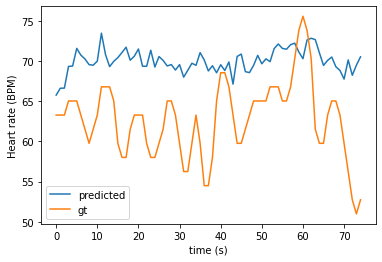

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = range(len(target))
ax.plot(pred[0].flatten(), label='predicted')
ax.plot(target, label='gt')
ax.set_xlabel('time (s)')
ax.set_ylabel('Heart rate (BPM)')
ax.legend();
plt.savefig('plots/predictedHR.pdf')

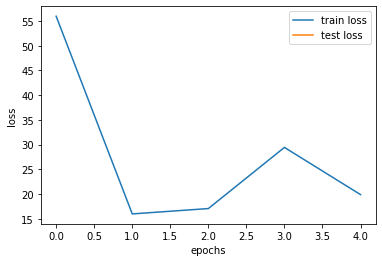

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_losses, label='train loss')
# ax.plot(test_losses, label='test loss')
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.legend();
plt.savefig('plots/loss.pdf')